# Importing nuclear time series from the ENTSO-E database

Nuclear reactors are typically considered non-dispatchable, because they cannot be easily tuned to follow the demand.
This notebook describes the extraction of actual production data in preparation for the optimal power flow computation.

In [1]:
import os, sys
sys.path.append('../TimeSeries/')

import time_series as ts
import entso_e

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Fetch the data

Directory containing the raw ENTSO-E data (see the notebook [doc/ENTSO-E_time_series](../doc/ENTSO-E_time_series.ipynb) for more info):

In [3]:
data_source = os.path.expanduser('~/data/entso-e/raw')

Select a reference year matching with the PanTaGruEl network:

In [4]:
year = 2016

Extract all nuclear data for that year:

In [5]:
data = entso_e.extract_production_by_unit_time_series(data_source, year, gen_type = 'Nuclear')

  0%|          | 0/12 [00:00<?, ?it/s]

For some years (2018 and 2019), an alternative import command must be used because of a different file format:

In [6]:
# data = entso_e.extract_production_by_unit_time_series_v2(data_source, year, gen_type = 'Nuclear ')

## Fit the European model 

Import the model file:

In [7]:
with open('../models/europe.json') as file:
    network = json.load(file)

List all model generators that have at least one reference in the nuclear dataset:

In [8]:
gen_ids = [int(id) for id, gen in network['gen'].items() if any(name in data.keys() for name in gen['entsoe_names'])]
gen_ids.sort()
len(gen_ids)

44

Compute periodic series for all the relevant model generators:

In [9]:
gen_series = np.array([sum(ts.make_364_periodic(data[name], year=year, verbose=False) for name in network['gen'][str(id)]['entsoe_names'])   
                       for id in gen_ids])

Compare the series' maximum with the given generator capacity:

In [10]:
gen_series_max = gen_series.max(axis=1)
gen_pmax = np.array([100 * network['gen'][str(id)]['pmax'] for id in gen_ids])
gen_series_max / gen_pmax

array([1.01587541, 0.8513535 , 1.03362289, 0.78214286, 1.08341969,
       1.01538971, 1.00205674, 0.99256776, 1.02513168, 1.02021028,
       1.0193323 , 1.0173617 , 0.98465909, 0.99145   , 1.00435106,
       0.92822695, 1.0475    , 1.00601027, 1.01566667, 1.01391534,
       0.99923664, 0.99453552, 1.02115385, 1.01103679, 1.0136612 ,
       1.02486339, 0.98876404, 0.75139665, 1.01825843, 1.01335878,
       0.99360902, 0.73082707, 1.00622711, 0.99442308, 1.00911602,
       1.00648855, 1.02125793, 1.01694215, 1.05655738, 1.0080429 ,
       1.00891089, 0.50547945, 1.01277099, 0.98345865])

Rescale the series as needed:

In [11]:
gen_scaling = gen_pmax / gen_series_max
gen_scaling = np.where(gen_scaling < 1., gen_scaling, 1.)
gen_scaling

array([0.98437268, 1.        , 0.96747083, 1.        , 0.92300335,
       0.98484355, 0.99794748, 1.        , 0.97548444, 0.98019008,
       0.98103435, 0.98293458, 1.        , 1.        , 0.99566779,
       1.        , 0.95465394, 0.99402563, 0.98457499, 0.98627564,
       1.        , 1.        , 0.97928437, 0.98908369, 0.98652291,
       0.9757398 , 1.        , 1.        , 0.98206897, 0.98681733,
       1.        , 1.        , 0.99381143, 1.        , 0.99096633,
       0.99355328, 0.97918456, 0.98334011, 0.94647013, 0.99202128,
       0.99116781, 1.        , 0.98739005, 1.        ])

In [12]:
gen_series_rescaled = gen_scaling.reshape((-1,1)) * gen_series

Arrange into a *Pandas* dataframe:

In [13]:
df = pd.DataFrame(gen_series_rescaled)
df.insert(0, 'id', gen_ids)
df

,id,0,1,2,3,4,5,6,7,8,...,8726,8727,8728,8729,8730,8731,8732,8733,8734,8735
0,79,1970.418797,1970.517235,1970.615672,1970.615672,1970.221923,1968.942238,1969.828174,1969.926611,1970.418797,...,1970.123485,1970.221923,1969.926611,1970.221923,1971.009421,1970.025048,1969.631299,1970.418797,1970.517235,1970.517235
1,87,1062.400000,1062.300000,1062.900000,1062.900000,1063.600000,1063.100000,1063.100000,1063.300000,1062.900000,...,1064.200000,1063.700000,1063.900000,1063.400000,1063.300000,1063.100000,1064.000000,1063.300000,1063.000000,1062.400000
2,160,975.113852,975.404093,975.791082,975.887829,975.694335,975.500840,975.887829,975.210599,975.500840,...,1901.080186,1836.646628,1668.693692,1495.419666,1336.077220,1228.784704,1132.811598,1047.577417,980.338195,975.113852
3,176,929.400000,927.900000,929.100000,929.300000,928.800000,929.500000,930.100000,929.900000,929.400000,...,932.100000,931.500000,931.300000,931.700000,931.300000,931.000000,930.700000,929.900000,929.600000,929.600000
4,179,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,...,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943,1914.308943
5,209,1274.289066,1273.599676,1247.698290,1276.849659,1277.342081,1277.637534,1309.940402,1334.364522,1355.046237,...,1263.160334,1276.849659,1276.849659,1264.243662,1258.728538,1276.455722,1275.470878,1277.637534,1273.205738,1273.107254
6,210,1208.244957,1208.244957,1207.865737,1207.865737,1207.865737,1207.865737,1206.298960,1210.689929,1204.871895,...,1212.087055,1211.538184,1210.809682,1210.689929,1210.640031,1230.199802,1210.640031,1210.260811,1210.240852,1208.444547
7,232,1364.000000,1361.730000,1355.300000,1353.000000,1359.550000,1359.300000,1372.880000,1377.980000,1372.150000,...,1370.580000,1371.650000,1369.600000,1364.400000,1362.800000,1369.200000,1366.430000,1369.650000,1361.780000,1363.500000
8,249,1272.714548,1274.665517,1274.372871,1273.007193,1274.372871,1280.420875,1320.903479,1321.878964,1321.586318,...,1281.884102,1282.079198,1288.322299,1299.150176,1295.540884,1296.223723,1296.126174,1298.564885,1293.980109,1290.956107
9,256,1203.477385,1203.379366,1203.085309,1202.301157,1200.830871,1200.242757,1199.948700,1198.772472,1198.184358,...,1202.889271,1202.301157,1202.301157,1202.595214,1202.203138,1202.693233,1202.595214,1203.085309,1203.281347,1203.477385


Export to a CSV file:

In [ ]:
df.to_csv('data/nuclear_%d.csv' % year, index=False, mode='x')

## Sample

In [15]:
swiss_gens = {
    # 917: 'Mühleberg',
    921: 'Gösgen',
    908: 'Leibstadt',
    943: 'Beznau'
}

In [16]:
def plot_swiss_nuclear(year, savefig = None):
    data = pd.read_csv('data/nuclear_%d.csv' % year, index_col='id') \
        .loc[swiss_gens.keys()].T \
        .rename(columns=swiss_gens)
    data.columns.name = ''
    data.plot()
    # plt.title('Nuclear in Switzerland - %d' % year)
    plt.xlim((0, 8736))
    plt.xlabel('Time [h]')
    plt.ylim((0, 1400))
    plt.ylabel('Power output [MW]')
    plt.legend(loc = 3)
    if savefig:
        plt.savefig(savefig)
    plt.show()

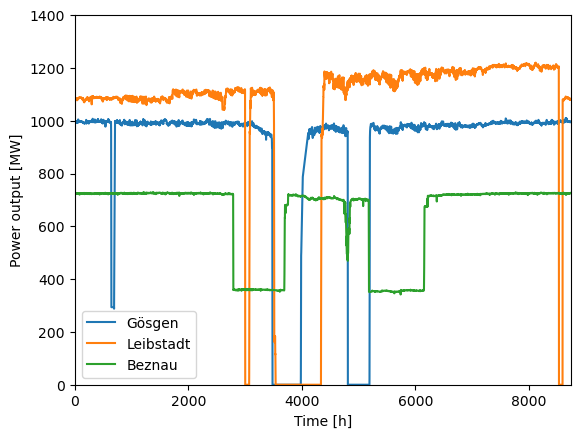

In [17]:
plot_swiss_nuclear(2019, 'figures/swiss_nuclear_2019.pdf')

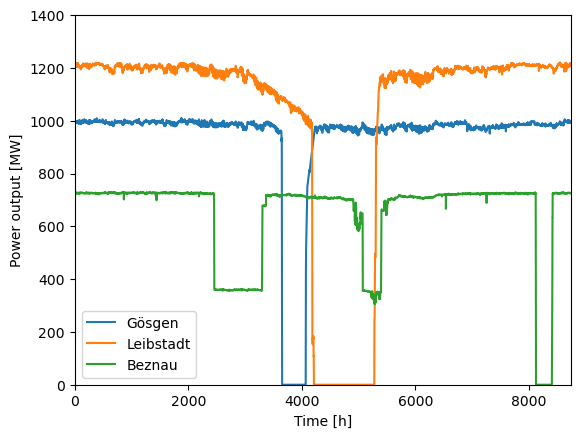

In [18]:
plot_swiss_nuclear(2020, 'figures/swiss_nuclear_2020.pdf')